In [501]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pickle

In [ ]:
# Face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image_gray):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    return faces

def crop_faces(image_gray, faces):
    if len(faces) == 0:
        return None
    (x, y, w, h) = faces[0]  # Only take the first face detected
    return image_gray[y:y+h, x:x+w]


In [ ]:
# Dateset load
dataset_dir = './images'
face_size = (128, 128)

X = []
y = []

label_names = []
label_dict = {}
current_label = 0

for root, dirs, files in os.walk(dataset_dir):
    for subdir in dirs:
        sub_path = os.path.join(root, subdir)
        for filename in os.listdir(sub_path):
            file_path = os.path.join(sub_path, filename)
            img = cv2.imread(file_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = detect_faces(gray)
            if len(faces) == 0:
                continue
            face_crop = crop_faces(gray, faces)
            if face_crop is not None:
                face_resized = cv2.resize(face_crop, face_size)
                X.append(face_resized.flatten())
                if subdir not in label_dict:
                    label_dict[subdir] = current_label
                    label_names.append(subdir)
                    current_label += 1
                y.append(label_dict[subdir])

X = np.array(X)
y = np.array(y)

print(f"Dataset loaded: {X.shape[0]} samples, {len(label_names)} classes.")


Dataset loaded: 66 samples, 7 classes.


In [ ]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 52
Testing samples: 14


In [505]:
# Build model
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% variance
    ('clf', SVC(kernel='linear', probability=True))
])

# Train Model
pipe.fit(X_train, y_train)

print("Model training completed!")


Model training completed!


In [506]:
# Evaluate
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_names))


                   precision    recall  f1-score   support

Bagus_Aryajatmiko       1.00      1.00      1.00         2
       Charli_XCX       1.00      0.33      0.50         3
    George_W_Bush       0.33      1.00      0.50         1
           Hindia       0.00      0.00      0.00         2
       Laura_Bush       0.50      1.00      0.67         2
  Serena_Williams       1.00      1.00      1.00         1
   Vladimir_Putin       1.00      0.33      0.50         3

         accuracy                           0.57        14
        macro avg       0.69      0.67      0.60        14
     weighted avg       0.74      0.57      0.56        14



In [507]:
# Saving into pickle
model_save_path = './face_recognition_model.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump((pipe, label_names), f)

print(f"Model saved to {model_save_path}")


Model saved to ./face_recognition_model.pkl


# Testing single image

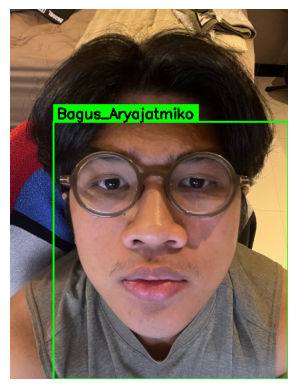

In [508]:
# Load a test image
test_img_path = './images/Bagus_Aryajatmiko/4.jpg'
test_img = cv2.imread(test_img_path)

if test_img is None:
    print("Error: Image not found.")
else:
    gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    faces = detect_faces(gray)
    if len(faces) == 0:
        print("No faces detected.")
    else:
        for (x, y, w, h) in faces:
            face_crop = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_crop, (128, 128))
            face_flat = face_resized.flatten().reshape(1, -1)

            # Predict
            pred = pipe.predict(face_flat)
            pred_prob = pipe.predict_proba(face_flat)
            label = label_names[pred[0]]

            # Final label text
            label_text = f"{label}"

            # Calculate text size
            (text_width, text_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)

            # Draw bounding box for face
            cv2.rectangle(test_img, (x, y, x + w, y + h), (0, 255, 0), 2)

            # Draw green background rectangle for label
            cv2.rectangle(
                test_img,
                (x, y - text_height - 10),
                (x + text_width + 10, y),
                (0, 255, 0),
                thickness=-1
            )

            # Put black text on top
            cv2.putText(
                test_img,
                label_text,
                (x + 5, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 0),
                2
            )

        # Show result
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()